#  Прогнозирование заказов такси

Компания-заказчик — сервис такси — на основе исторических данных о заказах такси в аэропортах хочет спрогнозировать количество заказов на следующий час, чтобы привлечь большее количество водителей в период пиковой нагрузки. 

Цель работы — построить модель, которая сможет спрогнозировать спрос на такси. Модель должна показать на тестовой выборке метрику RMSE не более 48 — то есть ошибаться не более, чем на 48 заказов в час.

Исходные данные (файл 'taxi.csv') хранят данные о заказах такси за каждые 10 минут. Дополнительных признаков (например, о проблемах в работе аэропорта) данные не содержат.

В ходе работы мы:
- подготовим данные для прогнозирования спроса в разрезе часа;
- добавим к ним необходимые признаки, на которые можно будет опираться в прогнозе;
- разделим данные на обучающую и тестовую выборку;
- обучим модели, построенные на основе разных алгоритмов, определим среди них лучшую;
- проверим работу лучшей модели на тестовой выборке.


## Подготовка данных

### Импорт библиотек

Перед загрузкой датасета выполним импорт всех необходимых библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error


from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import  RandomForestRegressor

### Обзор данных

Теперь загрузим датасет:

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


В исходном датасете всего два столбца — временной интервал `datetime` и количество заказов `num_orders`

Проверим, по порядку ли идут даты:

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'], infer_datetime_format=True)
data['datetime'].is_monotonic

True

Применим в качестве индекса для датасета дату

In [6]:
data = data.set_index('datetime')

### Ресемплирование

В текущий момент в датасете количество заказов показано в разрезе каждых 10 минут. "Укрупним" временные интервалы, выполнив ресемлирование на каждый час.

In [7]:
data = data.resample('1H').sum() # в качестве агрегирующей функции используем сумму заказов  

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

### Тренды и сезонность

Чтобы лучше понимать временной ряд, попробуем выявить в нем тренд и сезонность.

In [9]:
decomposed_data_hour = seasonal_decompose(data)

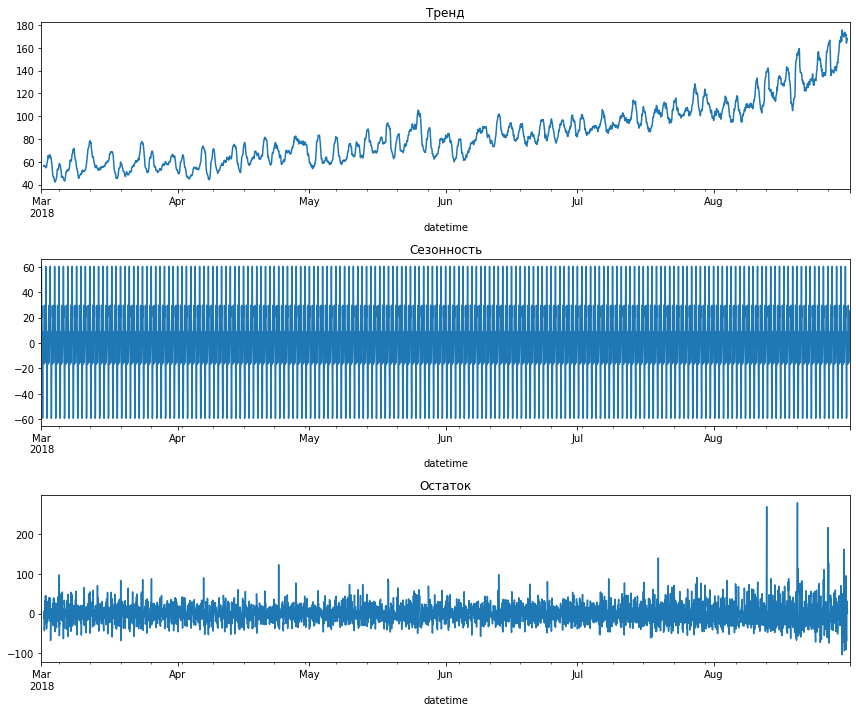

In [10]:
plt.figure(figsize=(12, 10))
plt.subplot(3,1,1)
decomposed_data_hour.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed_data_hour.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed_data_hour.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

При рассмотрении данных в текущем разрезе по часам мы видим возрастающий тренд, то есть растущий спрос на такси, но масштаб графика и количество данных не позволяет "прочесть" сезонность.

Повторим разделение на сезонность и тренд, увеличив интервалы до суток.

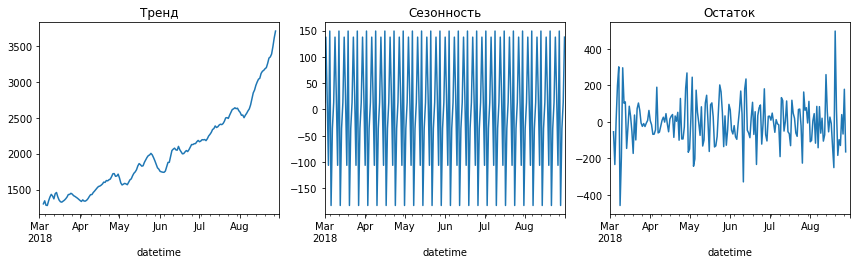

In [11]:
decomposed_data_by_day = seasonal_decompose(data.resample('1D').sum())
plt.figure(figsize=(12, 10))
plt.subplot(3,3,1)
decomposed_data_by_day.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(3,3,2)
decomposed_data_by_day.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(3,3,3)
decomposed_data_by_day.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Теперь мы уже видим повторяющий рисунок на графике сезонности, но масштаб все еще делает его не читабельным.
Посмотрим на данные за последние два месяца.

Text(0.5, 1.0, 'Сезонность')

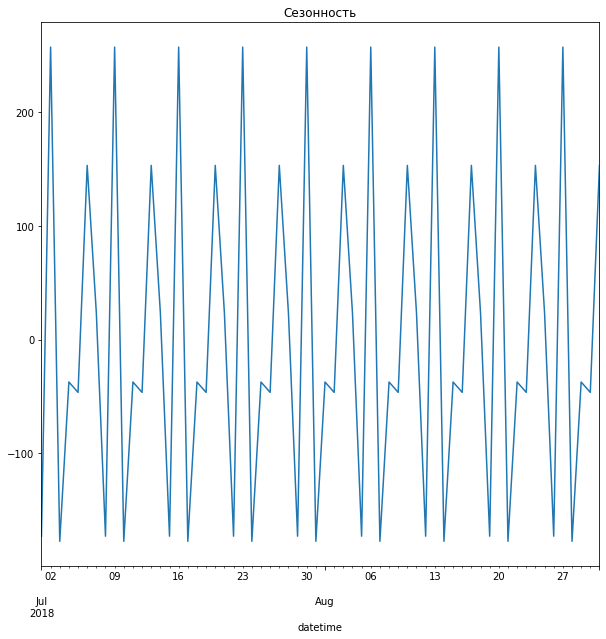

In [12]:
decomposed_data_by_day = seasonal_decompose(data['2018-07':'2018-08'].resample('1D').sum())

plt.figure(figsize=(10, 10))
decomposed_data_by_day.seasonal.plot()
plt.title('Сезонность')

Виден недельный "узор" — пик в начале недели (видимо в город прилетают в рабочие коммандировки), затем резкий спад и постепенный рост до пятницы.

Вернемся к почасовой декомпозиции — чтобы увидеть рисунок внутри дня, посмотрим только на последнюю неделю.

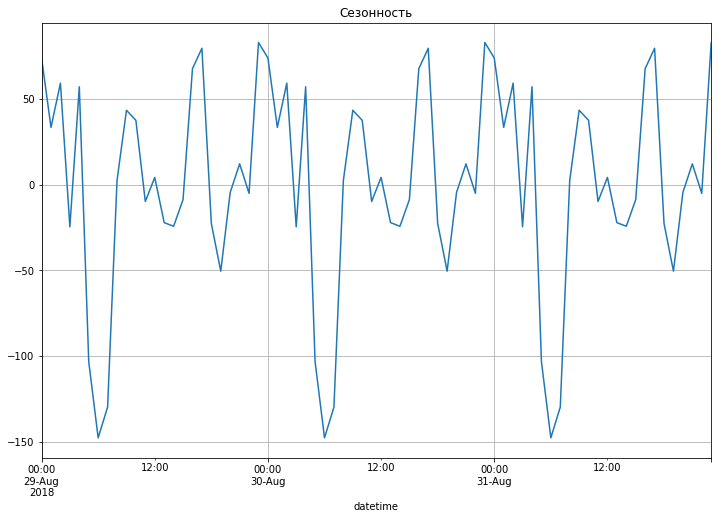

In [13]:
decomposed_data_hour = seasonal_decompose(data['2018-8-29':'2018-8-31'])
plt.figure(figsize=(12, 8))

decomposed_data_hour.seasonal.plot(grid=True)
plt.title('Сезонность')
plt.show()


На дневном графике видно, что пик заказов приходится примерно на полночь, когда заканчивает работу общественный транспорт. В течение ночи сохраняется высокий спрос на такси, затем к ~ 6 утра он падает (снова начинает работу общесвенный транспорт), однако к началу рабочего дня количество заказов снова растет (~ 8 утра). Умеренный спрос на услуги такси сохраняется в течение всего рабочего дня до 18:00, где наблюдается еще один пик заказов — после чего начинается спад. 

### Скользящее среднее 

Для анализа данных добавим в датасет скользящее среднее — в качестве шага установим 24 часа, т.е. сутки.

In [14]:
data['rolling_mean'] = data.rolling(24).mean() 

<AxesSubplot:xlabel='datetime'>

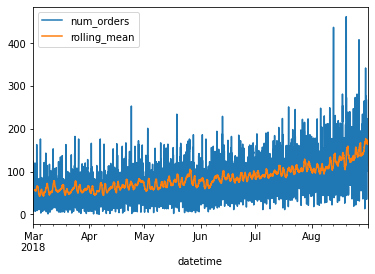

In [15]:
data.plot()

На графике видно, что скользящее среднее постенно растет, а значит, количество заказов увеличивается. При этом увеличивается и разброс количества заказов — т.е. увеличивается дисперсия, а временной ряд становится менее предсказуемым. Ту же картину мы наблюдали на графике сезонности и тренда.

Т. к. в дальнейшем мы хотим сделать скользящее среднее одним из настраеваемых признаков для обучения модели, сейчас удалим этот столбец из датасета.

In [16]:
data = data.drop(columns='rolling_mean')

## Обучение

### Создание признаков

Для обучения модели неоходимо создать признаки, по которым она сможет спрогнозировать будущие значения временного ряда. Для это определим функцию `make_features`, которая добавит в датасет день недели, день месяца, по желанию месяц, а также предыдущие значения временного ряда за необходимый срок и скользящее среднее с настраеваемым размером окна.

In [17]:
def make_data_features(data, max_lag, rolling_mean_size, month = False):
    """
    Эта функция добавляет признаки к временному ряду. Для корректной работы индекс датасета должен иметь формат datetime.
    
    На вход принимает датасет со значением временного ряда (data), период за который надо вывести отстающие значения (max_lag),
    размер окна для подсчета скользящего среднего (rolling_mean_size), а также необходимо ли добавить календарный признак месяц
    (month, булев тип, по умолчанию имеет значение False)
    
    Функция возвращает копию исходного датасет с добавлеными признаками:
    - календарные признаки `hour` — час, `dayofweek` — день недели, 'month' — месяц (если параметра month имел значение True);
    - отстающие значения — предыдущие значения врменного ряда, их количество будет равно параметру max_lag;
    - скользящее среднее, с размером окна rolling_mean_size.
    """
    data_modified = data.copy()
    
    if month:
        data_modified['month'] = data_modified.index.month
    
    data_modified['dayofweek'] = data_modified.index.dayofweek
    
    data_modified['hour'] = data_modified.index.hour    
    
    for lag in range(1, max_lag + 1):
        data_modified['lag_{}'.format(lag)] = data_modified['num_orders'].shift(lag)

    data_modified['rolling_mean'] = data_modified['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_modified

В случае если качество модели окажется низким, фунцию можно будет применить повторно, изменив передаваемые параметры.

In [18]:
data_mod = make_data_features(data, 24, 48) # временной лаг определим в 24 часа,
                                            # подсчитаем скользящее среднее за предыдущие двое суток
                                            # параметр month оставим по умолчанию, т.к. в датасете данные только за один год
                                            # и сезонность по месяцам не может быть выявлена

In [19]:
data_mod.head(25)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Признаки добавлены. Обратим внимание, что в первых rolling_mean_size строчках образовались пропуски.

### Разделение датасета на обучающую и тестовую выборки

Разделим датасет на обучающую и тестовую выборки. Для последней оставим 10% значений.

In [20]:
train, test = train_test_split(data_mod, shuffle=False, test_size=0.1)

In [21]:
train = train.dropna()

Теперь определим целевой признак и обучающие:

In [22]:
target_train = train['num_orders']
features_train = train.drop(columns=['num_orders'])

target_test = test['num_orders']
features_test = test.drop(columns=['num_orders'])

Проверим размерность массивов

In [23]:
target_train.shape

(3926,)

In [24]:
features_train.shape

(3926, 27)

In [25]:
target_test.shape

(442,)

In [26]:
features_test.shape

(442, 27)

### Создание объекта TimeSeriesSplit

Качество моделей мы будем проверять путем кросс-валидации, однако при работе с временными рядами использовать стандартную кросс-валидацию нельзя — применим объект TimeSeriesSplit из библиотеки sklearn для преодоления этого ограничения.


Количество долей на которые разделим обучающую выборку определим так, чтобы одна доля была примерно равна тестовой выборке. Т.к. на тестовую выборку мы определили 10%, то оставшиеся 90% которые приходятся на обучающую выборку, разделим на 9 частей.

In [27]:
tscv = TimeSeriesSplit(n_splits=9)

### Обучение линейной регрессии

Обучим модель линейной регрессии и проверим ее качество кросс-валидацией.

In [28]:
model = LinearRegression()


cross_val_score(model, features_train, target_train, cv=tscv, scoring ='neg_root_mean_squared_error').mean()

-26.546745136501116

Линейнай регрессия неплохо справляется с задачей — ошибка прогноза примерно 27 заказов в час.

### Обучение модели по алгоритму случайного леса

Сначала обучим модель Случайного леса. При ее обучении используем GridSearchCV для подбора гиперпарметров. Встроенная кросс-валидация позволит выявить лучшие параметры модели.

In [29]:
model = RandomForestRegressor(random_state = 1159)

parametrs = {'n_estimators' : range(10,100,20),
             'min_samples_split' : range(2,6,1)}

grid = GridSearchCV(model, parametrs, scoring = 'neg_root_mean_squared_error', cv=tscv)
grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
             estimator=RandomForestRegressor(random_state=1159),
             param_grid={'min_samples_split': range(2, 6),
                         'n_estimators': range(10, 100, 20)},
             scoring='neg_root_mean_squared_error')

In [30]:
grid.best_score_

-24.219903212919732

In [31]:
grid.best_params_

{'min_samples_split': 2, 'n_estimators': 90}

Модель с лучшими параметрами ошибается на ~ 24 заказов в час. Достаточно много, лучше линейной регрессии и меньше целевой планки заказчика.

### Обучение модели CatBoostRegressor

Теперь попробуем применить модель с использованием градиентного бустинга. Она дольше обучается, но заказчик не установил требование по времени, а точность предсказаний должна быть выше.

In [34]:
model = CatBoostRegressor(random_state = 1159)

grid = {'learning_rate': [0.1,0.2,0.5],
        'depth': [4, 6, 10]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       cv=tscv,
                                       plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 72.5474362	test: 107.4789438	best: 107.4789438 (0)	total: 49.9ms	remaining: 49.9s
1:	learn: 66.5717043	test: 100.7339539	best: 100.7339539 (1)	total: 52.7ms	remaining: 26.3s
2:	learn: 61.1538641	test: 94.3933524	best: 94.3933524 (2)	total: 55.1ms	remaining: 18.3s
3:	learn: 56.5059450	test: 89.2175089	best: 89.2175089 (3)	total: 57.6ms	remaining: 14.3s
4:	learn: 52.1555212	test: 83.8348607	best: 83.8348607 (4)	total: 60ms	remaining: 11.9s
5:	learn: 48.2830962	test: 79.6543817	best: 79.6543817 (5)	total: 62.2ms	remaining: 10.3s
6:	learn: 44.9592493	test: 75.4606016	best: 75.4606016 (6)	total: 64.6ms	remaining: 9.17s
7:	learn: 42.1480568	test: 71.9956767	best: 71.9956767 (7)	total: 67ms	remaining: 8.31s
8:	learn: 39.6968053	test: 68.8540795	best: 68.8540795 (8)	total: 69.4ms	remaining: 7.64s
9:	learn: 37.4194618	test: 65.7988974	best: 65.7988974 (9)	total: 71.9ms	remaining: 7.12s
10:	learn: 35.2486879	test: 62.3121381	best: 62.3121381 (10)	total: 74.2ms	remaining: 6.67s
11:	lear

RMSE модели с градиентным бустингом оказался неожиданно хуже более простых моделей — 30.7 — такой метрики удалось достичь при глубине `learning_rate` — 0.1 и `depth` равной 10.


## Тестирование

Проверим работу лучшей модели — RandomForestRegressor — на тестовой выборке — это позволит дать адекватную оценку эффективности ее применения.

In [35]:
model = RandomForestRegressor(random_state = 1159,
                              min_samples_split = 2,
                              n_estimators = 90)

In [36]:
model.fit(features_train, target_train)

RandomForestRegressor(n_estimators=90, random_state=1159)

In [37]:
predictions_RFR = model.predict(features_test) # сохраняем предсказания модели на тестовой выборке

In [38]:
mse_RFR = mean_squared_error(target_test,predictions_RFR)

In [39]:
rmse_RFR = mse_RFR**0.5
rmse_RFR

43.581439637769066

Целевая метрика достигнута.

## Вывод

В ходе работы были загружены и изучены данные по заказам такси в аэропорт. Для удобства обработки временных рядов в качестве индекса мы применили дату и время заказа.

Данные были ресемлированы с часовым интервалом. После этого мы посмотрели на имеющийся тренд и сезонность. Было отмечено, что спрос на услуги такси постепенно растет. Так как наш временной ряд был ресемплирован по часам, то сезонностью стала заметна на 24 часах (сутках) — было отмечено, что спрос растет ближе к ночи — когда прекращает работу общественный транспорт, затем в начале и конце рабочего дня (около 8 и 18 часов).

Для прогнозирования данных нами были созданы календарные признаки (день, день недели), скользящее среднее и отстающие значения — для точности прогнозирования мы взяли значения за предыдущие 24 часа (т.е. сутки).

При обучении лучшие результаты дала модель RandomForestRegressor — адекватность ее работы и была проверена на тестовой выборке. На ней модель достигла показателя RMSE ниже установленного заказчиком, а значит может быть взята в работу.

Учитывая сезонность и тренд, для лучшей точности предсказания можно использовать модель sARIMA (Сезонное авторегрессионное интегрированное скользящее среднее), однако ее применение требует более детальной предобработки данных.